In [14]:
import torch
from itertools import combinations
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt

In [15]:
from fuzz.utils import enumerate_permute, gap_count
from fuzz.src.capacity import *
from fuzz.src.norm import *
from fuzz.src.choquet import *
from fuzz.src.sim import *
from fuzz.src.knn import *
from fuzz.eval import FuzzLOO

### utils.py

In [16]:
x = torch.rand(300, 4)
print("done")
enum = enumerate_permute(x[1].unsqueeze(0))
print(enum)
print("shape", enum.shape)
gap_count(enum[0][0])

done
tensor([[[-1, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 0,  1, -1, -1],
         [ 0,  2, -1, -1],
         [ 0,  3, -1, -1],
         [ 1,  2, -1, -1],
         [ 1,  3, -1, -1],
         [ 2,  3, -1, -1],
         [ 0,  1,  2, -1],
         [ 0,  1,  3, -1],
         [ 0,  2,  3, -1],
         [ 1,  2,  3, -1],
         [ 0,  1,  2,  3]]])
shape torch.Size([1, 16, 4])


4

### capacity.py

In [17]:
mu = generate_capacity(enum[0])
for i in range(len(mu)):
    print(mu[i].get_capacity())

print(f"Capacity locator for {enum[0][4]}:", locate_capacity(enum[0][4], mu))

0
0.0380934476852417
0.04929906129837036
0.06893962621688843
0.13204097747802734
0.14982998371124268
0.150063157081604
0.1538606882095337
0.42363524436950684
0.5179548263549805
0.5239502191543579
0.5739595293998718
0.6184559464454651
0.831356406211853
0.9920271635055542
1
Capacity locator for tensor([ 3, -1, -1, -1]): 0.13204097747802734


### norm.py

In [18]:
x = normalize(x)
print("Normalized x:\n", x)

Normalized x:
 tensor([[0.0000, 0.7466, 0.1151, 1.0000],
        [0.0000, 0.7488, 0.7749, 1.0000],
        [0.0000, 0.9553, 1.0000, 0.3243],
        ...,
        [0.1232, 1.0000, 0.6972, 0.0000],
        [1.0000, 0.5753, 0.6277, 0.0000],
        [0.5257, 1.0000, 0.0000, 0.8692]])


In [19]:
x2 = torch.rand(300,4)
x2 = normalize(x2)
x2

tensor([[0.0893, 0.0188, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.3229, 0.2224],
        [0.7834, 0.5340, 0.0000, 1.0000],
        ...,
        [0.7717, 1.0000, 0.9348, 0.0000],
        [0.4205, 0.7698, 0.0000, 1.0000],
        [0.8962, 0.0587, 0.0000, 1.0000]])

In [20]:
T_norm_result = T_conorm(x, x2, mode='L')
T_norm_result

tensor([[0.0893, 0.7653, 0.1151, 1.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [0.7834, 1.0000, 1.0000, 1.0000],
        ...,
        [0.8950, 1.0000, 1.0000, 0.0000],
        [1.0000, 1.0000, 0.6277, 1.0000],
        [1.0000, 1.0000, 0.0000, 1.0000]])

### choquet.py

In [9]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result

tensor([[0.5840, 0.2361, 0.0613, 0.3862],
        [0.3619, 0.5906, 0.7044, 0.1805],
        [0.5155, 0.2110, 0.5715, 0.4975],
        ...,
        [0.2829, 0.6180, 0.8669, 0.4219],
        [0.1483, 0.7641, 0.7963, 0.3534],
        [0.4350, 0.4725, 0.3538, 0.6339]])

In [10]:
x[0]

tensor([0.5840, 0.2361, 0.9387, 0.3862])

In [11]:
enumerate_permute(x[0].unsqueeze(0))

tensor([[[-1, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 1,  3, -1, -1],
         [ 1,  0, -1, -1],
         [ 1,  2, -1, -1],
         [ 3,  0, -1, -1],
         [ 3,  2, -1, -1],
         [ 0,  2, -1, -1],
         [ 1,  3,  0, -1],
         [ 1,  3,  2, -1],
         [ 1,  0,  2, -1],
         [ 3,  0,  2, -1],
         [ 1,  3,  0,  2]]])

In [12]:
choquet = Choquet(X=x[0].unsqueeze(0), mu=mu)

In [13]:
choquet.choquet

0.49531450867652893

### sim.py

In [14]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result[0].unsqueeze(0)

tensor([[0.5840, 0.2361, 0.0613, 0.3862]])

In [15]:
choquet2 = Choquet(X=s_union_result[0].unsqueeze(0), mu=mu)
choquet2.choquet

0.27083420753479004

In [16]:
for i in range(5):
    sim = S1(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim1:", sim.score())
    sim = S2(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim2:", sim.score())
    sim = S3(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim3:", sim.score())
    print()

Sim1: 0.6710402085175017
Sim2: 0.586264645505317
Sim3: 0.5669671097235928

Sim1: 0.22251087849014392
Sim2: 0.22691783347086578
Sim3: 0.17585306885642002

Sim1: 0.5895098850910718
Sim2: 0.6276060834075832
Sim3: 0.5949843379352752

Sim1: 0.16632426577024814
Sim2: 0.16421477510764343
Sim3: 0.11930248430524396

Sim1: 0.24716316289667786
Sim2: 0.25703049054936616
Sim3: 0.20072083998579504



### knn.py

In [17]:
label = torch.randint(0, 2, (300, ))

In [19]:
knn = KNNFuzz(input_dimension=x.size(1), mu=mu, k=3, sim=S1)
knn.fit(desc_set=x, label_set=label)
knn.accuracy(desc_set=x, label_set=label)

tensor(0.5433)

In [60]:
import time 
import copy

In [61]:
X = x 
Y = label

In [62]:
C = KNNFuzz(input_dimension=3, mu=mu, k=3, sim=S1)

In [63]:
FuzzLOO(
    C = C,
    DS = (x, label),
    mu = mu,
    time_counter=True
)

Result in 36.2065 seconds.


0.5633333333333334

### eval.py

Leave one out avec k = 1
SimLevel1: 0.5066666666666667
SimLevel2: 0.5333333333333333
SimLevel3: 0.52

Result in 132.6657 seconds.
Leave one out avec k = 2
SimLevel1: 0.54
SimLevel2: 0.5166666666666667
SimLevel3: 0.53

Result in 136.2795 seconds.
Leave one out avec k = 3
SimLevel1: 0.5266666666666666
SimLevel2: 0.5066666666666667
SimLevel3: 0.51

Result in 135.5242 seconds.
Leave one out avec k = 4
SimLevel1: 0.5066666666666667
SimLevel2: 0.5233333333333333
SimLevel3: 0.51

Result in 134.1169 seconds.
Leave one out avec k = 5
SimLevel1: 0.52
SimLevel2: 0.4866666666666667
SimLevel3: 0.5033333333333333

Result in 133.3782 seconds.
Leave one out avec k = 6
SimLevel1: 0.5033333333333333
SimLevel2: 0.5066666666666667
SimLevel3: 0.49333333333333335

Result in 133.4173 seconds.
Leave one out avec k = 7
SimLevel1: 0.51
SimLevel2: 0.5033333333333333
SimLevel3: 0.49666666666666665

Result in 136.7962 seconds.
Leave one out avec k = 8
SimLevel1: 0.5033333333333333
SimLevel2: 0.5033333333333333
Sim

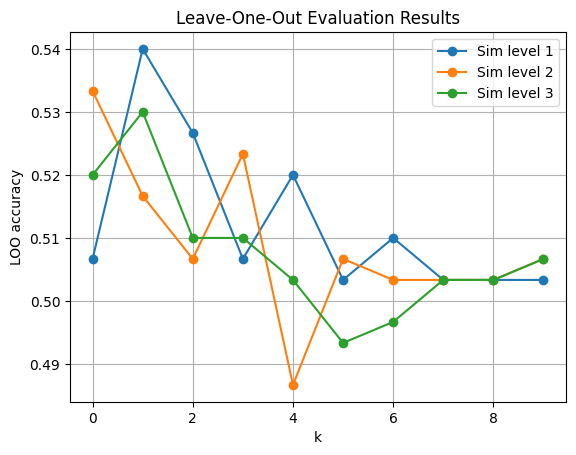

In [64]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute(x[0].unsqueeze(0))[0])

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S1), 
            DS = (x, label),
            mu=mu
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S2), 
            DS = (x, label),
            mu=mu
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S3), 
            DS = (x, label),
            mu=mu
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()

In [65]:
class NCATransform(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = torch.nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)

    def forward(self, x):
        return torch.matmul(x, self.A.t())


In [31]:
class NCAFuzzKNN(KNNFuzz):
    """
    NCA Fuzz KNN Classifier
    """
    def __init__(
            self,
            input_dimension: int,
            mu: List[Capacity],
            k: int = 3,
            output_dimension: int = None,
            sim: FuzzSIM = S1
    ):
        """
        NCA Fuzz KNN Classifier

        Parameters
        ----------
        input_dimension : int
            Dimension of the input data.
        mu : List[Capacity]
            List of capacities.
        k : int
            Number of neighbors to consider.
        output_dimension : int
            Dimension of the output data.
        sim : FuzzSIM
            Similarity measure to use.
        """
        super().__init__(input_dimension=input_dimension, mu=mu, k=k, sim=sim)

        # Set output dimension (for dimensionality reduction if needed)
        if output_dimension is None:
            output_dimension = input_dimension
        self.output_dimension = output_dimension

        # Initialize NCA model
        self.nca = NCATransform(input_dimension, output_dimension)
        
        # Store transformed data
        self.transformed_desc_set = None

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Transform the input data using the NCA model.

        Parameters
        ----------
        x : torch.Tensor
            Input data.

        Returns
        -------
        torch.Tensor
            Transformed data.
        """
        # Apply the transformation
        return self.nca(x)
    
    def compute_pij(self, transformed_x: torch.Tensor, mu_transformed: List[Capacity]) -> torch.Tensor:
        """
        Compute the stochastic neighbor probabilities p_ij based on fuzzy similarities.
        
        Parameters:
        -----------
        transformed_data : torch.Tensor
            Data in the transformed space
        mu : List[Capacity]
            List of capacity functions for fuzzy similarity

        Note: Remember to regenerate the mu list for the transformed data
        Returns:
        --------
        np.ndarray
            Stochastic neighbor probability matrix
        """
        n = transformed_x.size(0)

        # Compute pairwise similarities
        sim_matrix = torch.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:  # Exclude self-similarity
                    sim_matrix[i, j] = S1(transformed_x[i].unsqueeze(0), transformed_x[j].unsqueeze(0), mu_transformed).score()

        # Convert to torch tensor
        sim_tensor = torch.tensor(sim_matrix, dtype=torch.float32)

        # Apply softmax to get probabilities
        # We need to handle the diagonal separately (set to 0)
        mask = torch.eye(n, dtype=torch.bool)
        sim_matrix.masked_fill_(mask, float('-inf'))  # Set diagonal to -inf

        # Apply softmax row-wise
        pij = torch.softmax(sim_matrix, dim=1)

        return pij
        
    def loss(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the loss function for the NCA Fuzz KNN classifier.

        Parameters
        ----------
        x : torch.Tensor
            Input data.
        labels : torch.Tensor
            Labels for the input data.

        Returns
        -------
        torch.Tensor
            Loss value.
        """
        # Transform the input data
        transformed_x = self.transform(x)

        # Normalize the transformed data
        transformed_x = normalize(transformed_x)

        # Regenerate the mu list for the transformed data
        mu_transformed = generate_capacity(enumerate_permute(transformed_x[0].unsqueeze(0))[0])

        # Compute the stochastic neighbor probabilities p_ij
        pij = self.compute_pij(transformed_x, mu_transformed)

        # Create a mask for same-class examples
        n = x.size(0)
        same_class = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()
        mask = torch.eye(n, dtype=torch.bool)
        same_class.masked_fill_(mask, 0)  # Exclude self-similarity

        # Sum p_ij over all j in the same class as i
        pi = (pij * same_class).sum(dim=1)  # shape: [n]
        
        # Maximize sum(pi) ⇒ minimize -sum(pi)
        loss = -torch.sum(pi)
        
        return loss
    
    def fit(
            self, 
            desc_set: torch.Tensor,
            label_set: torch.Tensor,
            num_epochs: int = 100,
            learning_rate: float = 0.01,
            batch_size: int = 32,
    ):
        """
        Fit the NCA Fuzz KNN classifier to the training data.

        Parameters
        ----------
        desc_set : torch.Tensor
            Description set (features).
        label_set : torch.Tensor
            Label set (targets).
        mu : List[Capacity]
            List of capacities.
        num_epochs : int
            Number of epochs for training.
        learning_rate : float
            Learning rate for the optimizer.
        batch_size : int
            Batch size for training.

        Returns
        -------
        None
        """
        self.desc_set = desc_set
        self.label_set = label_set

        # Initialize optimizer
        optimizer = torch.optim.Adam([self.nca.A], lr=learning_rate)

        n_samples = len(desc_set)        
        # mini-batch or full batch
        if batch_size is None:
            batch_size = n_samples

        # Train the model
        losses = []
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            epoch_loss = 0

            # Shuffle the data for mini-batch training
            indices = torch.randperm(n_samples)

            # Mini-batch training
            for start_idx in range(0, n_samples, batch_size):
                # Get mini-batch indices
                batch_indices = indices[start_idx:min(start_idx + batch_size, n_samples)]
                
                # Get batch data
                batch_x = desc_set[batch_indices]
                batch_y = label_set[batch_indices]

                # Regenerate the mu list for the batch
                mu_transformed = generate_capacity(enumerate_permute(batch_x[0].unsqueeze(0))[0])
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Compute loss
                loss = self.loss(x=batch_x, labels=batch_y)
                print("loss", loss)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * len(batch_indices)
            
            # Average loss for the epoch
            avg_loss = epoch_loss / n_samples
            losses.append(avg_loss)
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        
        # Transform the training data using the learned transformation
        self.transformed_desc_set = self.transform(desc_set)
        
        print(f"NCA training complete. Final loss: {losses[-1]:.4f}")

        return losses

In [32]:
nca = NCAFuzzKNN(
    input_dimension=x.size(1),
    mu = mu,
    k = 3,
    sim = S1,
    output_dimension=3
)
transformed_x = nca.transform(x)
print(transformed_x.size())
transformed_x = normalize(transformed_x)

# Regenrate mu for transformed data
mu_transformed = generate_capacity(enumerate_permute(transformed_x[0].unsqueeze(0))[0])

torch.Size([300, 3])


In [23]:
label = torch.randint(0, 2, (300, ))

In [24]:
# loss pretesting
loss = nca.loss(x, label)
print(loss)
print(f"loss.grad_fn: {loss.grad_fn}")


/var/folders/p4/7wm8j7tn0n316fy23dlvdbq40000gn/T/ipykernel_64606/2562740461.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_tensor = torch.tensor(sim_matrix, dtype=torch.float32)


tensor(-149.8846, grad_fn=<NegBackward0>)
loss.grad_fn: <NegBackward0 object at 0x10770f6a0>


In [25]:
for name, param in nca.nca.named_parameters():
    print(f"{name} requires_grad = {param.requires_grad}")

A requires_grad = True


In [33]:
losses = nca.fit(
    desc_set=x, 
    label_set=label,
    num_epochs=100,
    learning_rate=0.01,
    batch_size=32,
)


Epoch 1/100


/var/folders/p4/7wm8j7tn0n316fy23dlvdbq40000gn/T/ipykernel_64606/2328566818.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_tensor = torch.tensor(sim_matrix, dtype=torch.float32)


loss tensor(-15.7253, grad_fn=<NegBackward0>)
loss tensor(-15.3103, grad_fn=<NegBackward0>)
loss tensor(-15.4884, grad_fn=<NegBackward0>)
loss tensor(-15.7932, grad_fn=<NegBackward0>)
loss tensor(-15.6960, grad_fn=<NegBackward0>)
loss tensor(-16.4837, grad_fn=<NegBackward0>)
loss tensor(-15.4830, grad_fn=<NegBackward0>)
loss tensor(-17.7843, grad_fn=<NegBackward0>)
loss tensor(-15.9891, grad_fn=<NegBackward0>)
loss tensor(-10.1424, grad_fn=<NegBackward0>)
Epoch 2/100
loss tensor(-15.3706, grad_fn=<NegBackward0>)
loss tensor(-15.3996, grad_fn=<NegBackward0>)
loss tensor(-17.0961, grad_fn=<NegBackward0>)
loss tensor(-15.8054, grad_fn=<NegBackward0>)
loss tensor(-17.6058, grad_fn=<NegBackward0>)
loss tensor(-15.7079, grad_fn=<NegBackward0>)
loss tensor(-17.0789, grad_fn=<NegBackward0>)
loss tensor(-15.4460, grad_fn=<NegBackward0>)
loss tensor(-16.2940, grad_fn=<NegBackward0>)
loss tensor(-6.5084, grad_fn=<NegBackward0>)
Epoch 3/100
loss tensor(-15.5709, grad_fn=<NegBackward0>)
loss tensor

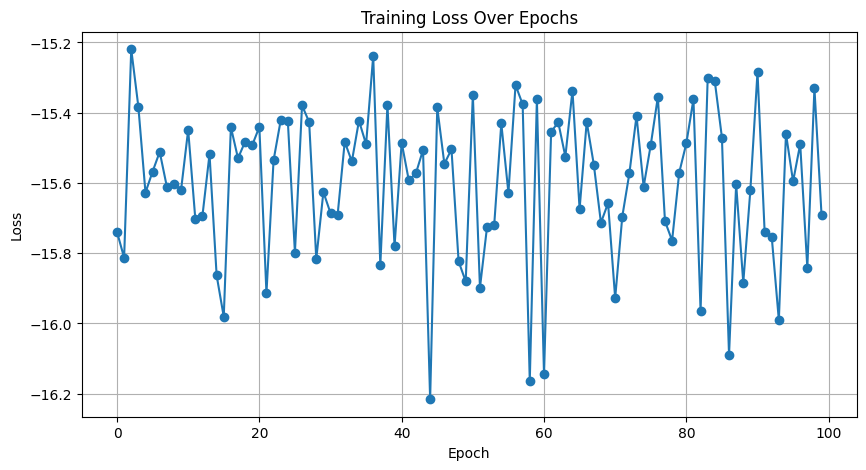

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

#### Test compute pij

In [38]:
pij = nca.compute_pij(transformed_x, mu_transformed)

/var/folders/p4/7wm8j7tn0n316fy23dlvdbq40000gn/T/ipykernel_46695/1515651996.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_tensor = torch.tensor(sim_matrix, dtype=torch.float32)


<Axes: >

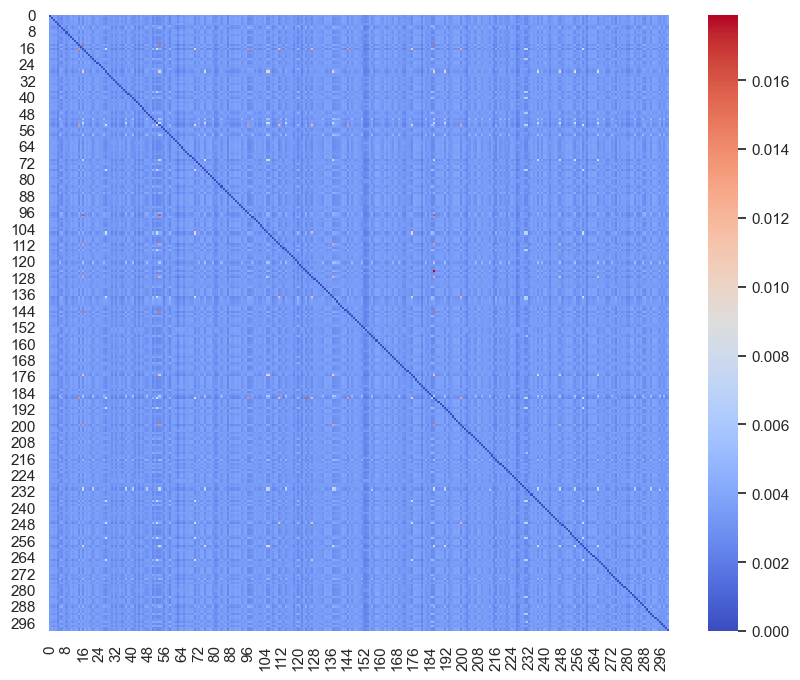

In [39]:
test = pij.numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')

#### NCA loss

In [47]:
optimizer = torch.optim.Adam([nca.nca.A], lr=1e-3)

In [58]:
for i in range(5):
    print("Epoch", i)
    epoch_loss = 0
    # Shuffle the data for mini-batch training
    indices = torch.randperm(10)

    # Mini-batch training
    for start_idx in range(0, 10, 21):
        # Get mini-batch indices
        batch_indices = indices[start_idx:min(start_idx + 21, 10)]

        # Get batch data
        batch_x = x[batch_indices]
        batch_y = label[batch_indices]

        # Regenerate mu for transformed data
        mu_transformed = generate_capacity(enumerate_permute(batch_x[0].unsqueeze(0))[0])

        # Zero the gradients
        # optimizer.zero_grad()

        # Compute loss
        loss = nca.loss(x=batch_x, labels=batch_y)
        print("Loss:", loss.item())

        # Backward pass and optimization
        # loss.backward()
        # optimizer.step()
        
        epoch_loss += loss.item() * len(batch_indices)
    

Epoch 0
Loss: -4.5294575691223145
Epoch 1
Loss: -4.664021968841553
Epoch 2
Loss: -4.588067054748535
Epoch 3
Loss: -4.592399597167969
Epoch 4
Loss: -4.695333957672119


/var/folders/p4/7wm8j7tn0n316fy23dlvdbq40000gn/T/ipykernel_46695/319951124.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_tensor = torch.tensor(sim_matrix, dtype=torch.float32)


In [26]:
print(transformed_x.min(), transformed_x.max())

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


In [22]:
n = transformed_x.size(0)
sim_matrix = torch.zeros((n, n))

mu_transformed = generate_capacity(enumerate_permute(transformed_x[0].unsqueeze(0))[0])


In [23]:
for i in range(n):
    for j in range(n):
        if i != j:  # Exclude self-similarity
            sim_matrix[i, j] = S1(transformed_x[i].unsqueeze(0), transformed_x[j].unsqueeze(0), mu_transformed).score()

<Axes: >

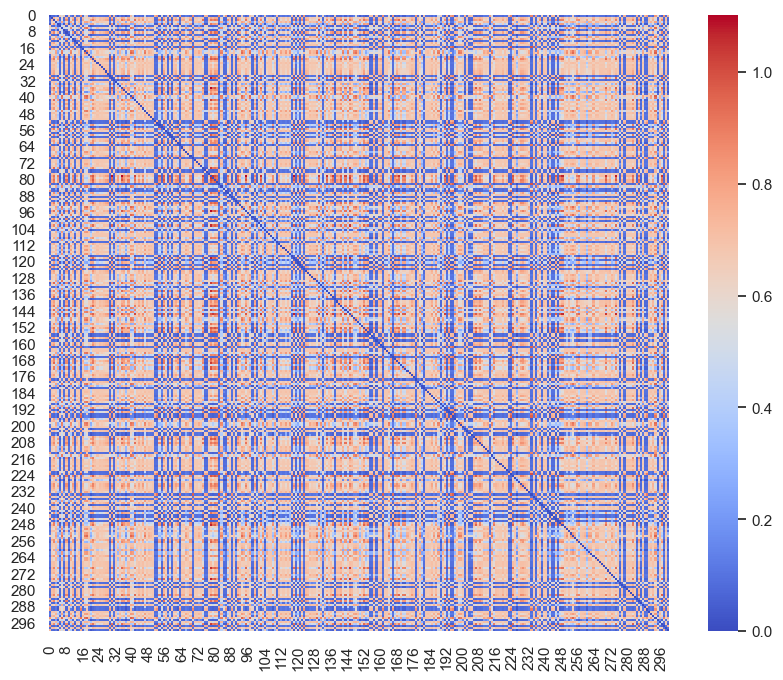

In [24]:
test = sim_matrix.numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')

In [27]:
mask = torch.eye(n, dtype=torch.bool)
sim_matrix.masked_fill_(mask, float('-inf'))  # Set diagonal to -inf

tensor([[  -inf, 0.0836, 0.0711,  ..., 0.8471, 0.0898, 0.7164],
        [0.0836,   -inf, 0.7617,  ..., 0.0842, 0.6981, 0.0824],
        [0.0711, 0.7617,   -inf,  ..., 0.0715, 0.7188, 0.0702],
        ...,
        [0.8471, 0.0842, 0.0715,  ...,   -inf, 0.0905, 0.7444],
        [0.0898, 0.6981, 0.7188,  ..., 0.0905,   -inf, 0.0885],
        [0.7164, 0.0824, 0.0702,  ..., 0.7444, 0.0885,   -inf]])

In [29]:
pij = torch.softmax(sim_matrix, dim=1)

<Axes: >

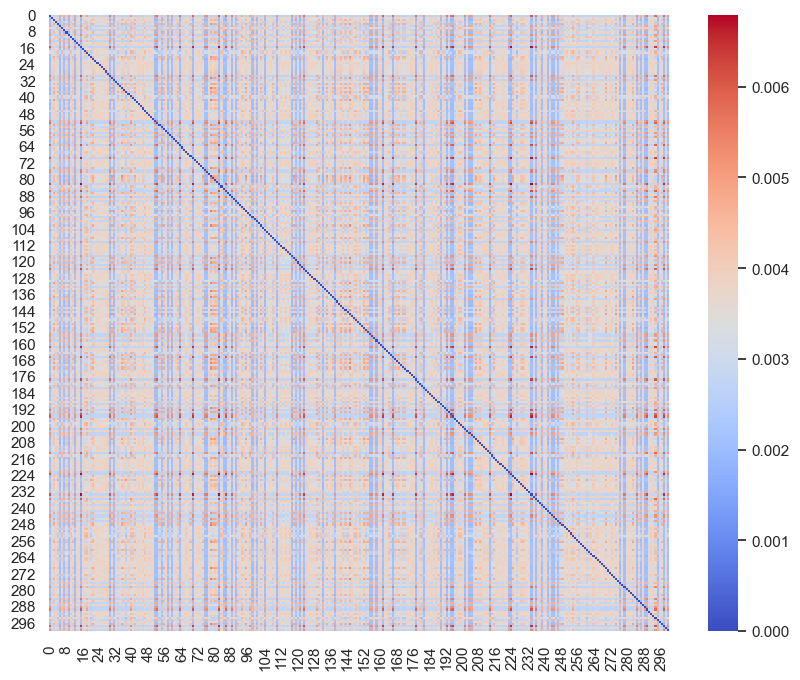

In [30]:
test = pij.numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')